In [1]:
import h5py
import numpy as np   
import matplotlib.pyplot as plt

from grav_waldo.wfdset import LoadNR, DsetBuilder, DataGen

<font size=3.5> 

**wfdset** module presents three classes to deal with the whole pre-training process:

* *LoadNR* - loads waveforms and source parameters from a Numerical Relativity (NR) database;
* *DsetBuilder* - builds the neural network (NN) dataset with all feature engineering;
* *DataGen* - dataset generator to return data batchs during the NN training.

### **LoadNR:**

In [2]:
nr = LoadNR(path_load="database/", wf_file="rhOverM")

print(nr.__doc__)


    LoadNR is developed to load SXS¹ data. The metadata and waveforms (wfs) files must have the 
    format ID_metadata.txt and ID_WFfile.h5, where "ID" is the identification number and "WFfile"
    wf file name. In particular, we adopt "ID_rhOverM.h5" and "ID_rMPsi4.h5" names in our database.
    The list of the identification number can be accessed by the attribut "IDs".

    The class initializes with two parameters:
    · path_load: the path directory where the database is stored;
    · wf_file: the waveform name.
    

    There are four methods:
    → masses(): returns the (m1, m2) masses of the binaries after the simulation relaxation 
      time;

    → spins(): returns the (χ1, χ2) dimensionless spins of the binaries after the simulation 
      relaxation time;

    → eccentricity(): returns the orbital eccentricity of the binaries after the simulation 
      relaxation time;

    → waveform(modes): returns (t, wfs) with the respective array shapes, (number-simulations, ) 
  

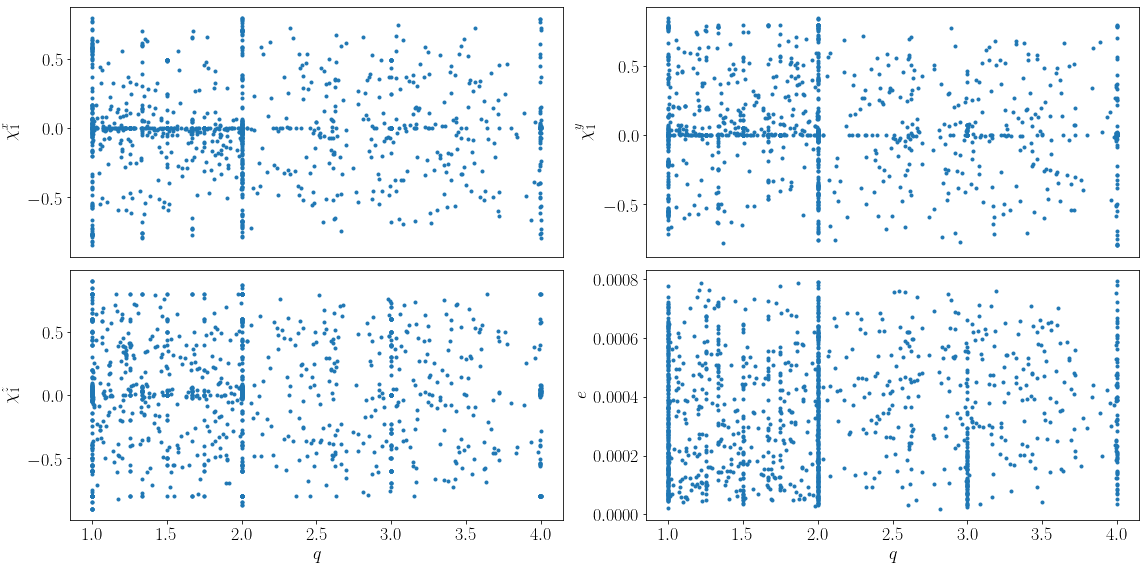

In [3]:
m1, m2 = nr.masses()
q = m1/m2

χ1, χ2 = nr.spins()
e = nr.eccentricity()

plt.rcParams.update({"text.usetex": True,
                     "font.family": "DejaVu Sans"})

fig, ax = plt.subplots(2, 2, figsize=(16, 8))

ax[0,0].plot(q, χ1.T[0], '.')
ax[0,0].set_ylabel("$\chi_1^x$", fontsize=18)
ax[0,0].yaxis.set_tick_params(labelsize=18)
ax[0,0].set_xticks([])

ax[0,1].plot(q, χ1.T[1], '.')
ax[0,1].set_ylabel("$\chi_1^y$", fontsize=18)
ax[0,1].yaxis.set_tick_params(labelsize=18)
ax[0,1].set_xticks([])

ax[1,0].plot(q, χ1.T[2], '.')
ax[1,0].set_ylabel("$\chi_1^z$", fontsize=18)
ax[1,0].set_xlabel("$q$", fontsize=18)
ax[1,0].yaxis.set_tick_params(labelsize=18)
ax[1,0].xaxis.set_tick_params(labelsize=18)

ax[1,1].plot(q, e, '.')
ax[1,1].set_ylabel("$e$", fontsize=18)
ax[1,1].set_xlabel("$q$", fontsize=18)
ax[1,1].yaxis.set_tick_params(labelsize=18)
ax[1,1].xaxis.set_tick_params(labelsize=18)

fig.subplots_adjust(wspace=0.5, hspace=0.)
plt.tight_layout(pad=1.0)

plt.show()

Simulation SXS:BBH:1830:

q = 2.62

χ1 = [ 0.12506861 -0.10801508  0.37308222]

χ2 = [-0.71955599 -0.14402116  0.14376279]

e = 0.0001545



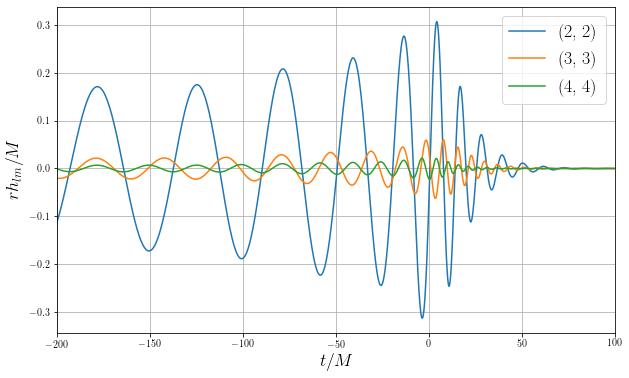

In [5]:
modes = [(2,2), (3,3), (4,4)]

t, wfs = nr.waveform(modes)

i = 0 
print(f"Simulation SXS:BBH:{nr.IDs[i]}:\n")

print(f"q = {q[i]:.2f}\n")
print(f"χ1 = {χ1[i]}\n")
print(f"χ2 = {χ2[i]}\n")
print(f"e = {e[i]}\n")

plt.rcParams.update({"text.usetex": True,
                     "font.family": "DejaVu Sans"})

plt.figure(figsize=(10,6))
for (l, m), h in zip(modes, wfs[i]):
    plt.plot(t[i], h.real, label=f"({l}, {m})")
plt.ylabel("$rh_{lm}/M$", fontsize=18)
plt.xlabel("$t/M$", fontsize=18)
plt.legend(fontsize=18)
plt.xlim(-200, 100)
plt.grid()
plt.show()

### **DsetBuilder:**

In [6]:
Modes = [(l, m) for l in range(2, 4+1) for m in range(l, -1, -1) if abs(m) >= l-1]

print(Modes)

[(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3)]


In [7]:
dset = DsetBuilder(path_load="database/", 
                   wf_file="rMPsi4",
                   path_save="dataset/dset_wfsHM", 
                   Nt=2048, 
                   modes=Modes)

print(dset.__doc__)

# To create a new dataset, just run the "dset" object as a function:
# dset() 


    DsetBuilder uses loadNR to access the binaries parameters and their waveforms (wfs). 
    The wfs are interpolated and reformed to start at the shortest database initial time 
    and finish after 100 solar masses of the dominant mode amplitude peak. The time 
    interpolation provides more data points during merger-ringdown stages of the 
    coalescence.


    The class initializes with five parameters:
    · path_load: the path directory where the NR database is stored;
    · wf_file: the waveform name;
    · path_save: the path/name of the built dataset;
    · Nt: the timeseries size integer number;
    · modes: a list of tuples containing the "l" and "m" mode number.


    It returns in a single h5 file:
    > dataset "X": the binaries parameters (mass-ratio, spins, and eccentricity) 
      linearized for the range [0,1];

    > dataset "y": the real and imaginary parts of the waveforms;

    > dataset "wf_IDs": the list of the identification simulation numbers;

    - attri

### **DataGen:**

In [8]:
dset = DsetBuilder()

path_dset = "dataset/dset_wfsHM"

with h5py.File(path_dset + ".h5", "r") as f:
    X_shape = np.array(f['X']).shape
    y_shape = np.array(f['y']).shape
    
_, latent_dim = X_shape
Nf, Nt, _ = y_shape

IDs = np.random.randint(low=0, high=Nf, size=3)

# Defining data generators and parameters:
args = {'IDs':IDs, 'batch_size':1, 'shuffle':True, 'path_dset':path_dset}

data = DataGen(**args)

print(data.__doc__)


    DataGen is a batch dataset generator for TensorFlow/Keras framework.


    The class initializes with four parameters:
    · IDs: the index dataset list;
    · batch_size: the batch-size integer number;
    · shuffle: the boolean parameter for shuffling the IDs numbers;
    · path_dset: the dataset path/name to be loaded.


    The method attached_data() returns the dataset attributes. 
    See DsetBuilder documentation.


    It returns the (X, y) batch, where:
    > X is the binaries parameters;
    > y is the real and imaginary parts of the waveforms.
    


Nf = 8046, Nt = 2048

ID = 1193, p = [ 1.99998550e+00  7.65805466e-01 -3.62001725e-01  6.92362011e-02
  7.92812667e-01 -2.96725408e-01  7.43941754e-02  6.15699993e-04]

ID = 472, p = [ 1.99470227e+00 -2.72161868e-02  1.41211507e-01  6.82509050e-02
 -1.69970780e-02  1.64021024e-03 -7.01790437e-01  5.80000007e-05]

ID = 765, p = [ 2.00003729e+00 -4.25426948e-01 -6.77092287e-01 -2.36072487e-02
  6.73292744e-01 -4.11684702e-01  1.30499193e-01  3.16899995e-04]



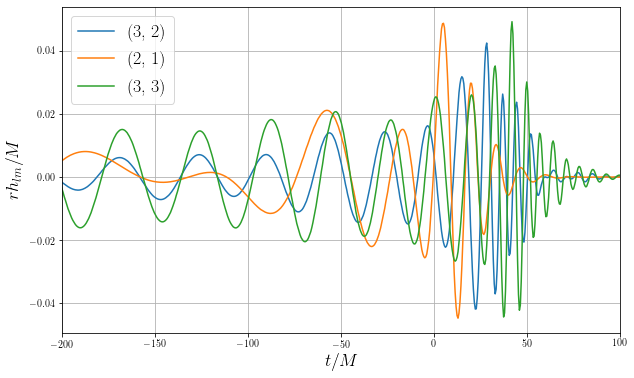

In [9]:
wf_IDs, Cij, modes, shift, norm, t = data.attached_data()

l_size = modes[-1][0] - 1
m_size = modes[-1][0] - modes[-1][-1] + 1

print(f"Nf = {Nf}, Nt = {Nt}\n")

plt.rcParams.update({"text.usetex": True,
                     "font.family": "DejaVu Sans"})

plt.figure(figsize=(10,6))
for wf_ID, (X, y) in zip(wf_IDs, data):
        
    p = dset.paramBack(X[0][l_size+m_size:], Cij)
    print(f"ID = {wf_ID[0]}, p = {p}\n")
    
    l = 2 + int(np.argmax(X[0][0:l_size]))
    m = l - int(np.argmax(X[0][l_size:l_size+m_size])) 
    
    h = norm*(y.T[0] + 1j*y.T[1])*np.exp(1j*shift)
    
    plt.plot(t, h.real, '-', label=f"({l}, {m})")
    
plt.ylabel("$rh_{lm}/M$", fontsize=18)
plt.xlabel("$t/M$", fontsize=18)
plt.legend(fontsize=18)
plt.xlim(-200, 100)
plt.grid()
plt.show()   